Starting readings...
Line does not contain A0 data: Total Time: 3000104 us, Total Readings: 750
Dimension of data_a0: 750
Dimension of data_a2: 750
Dimension of data_a3: 750
Dimension of data_a4: 750
Dimension of data_a5: 750


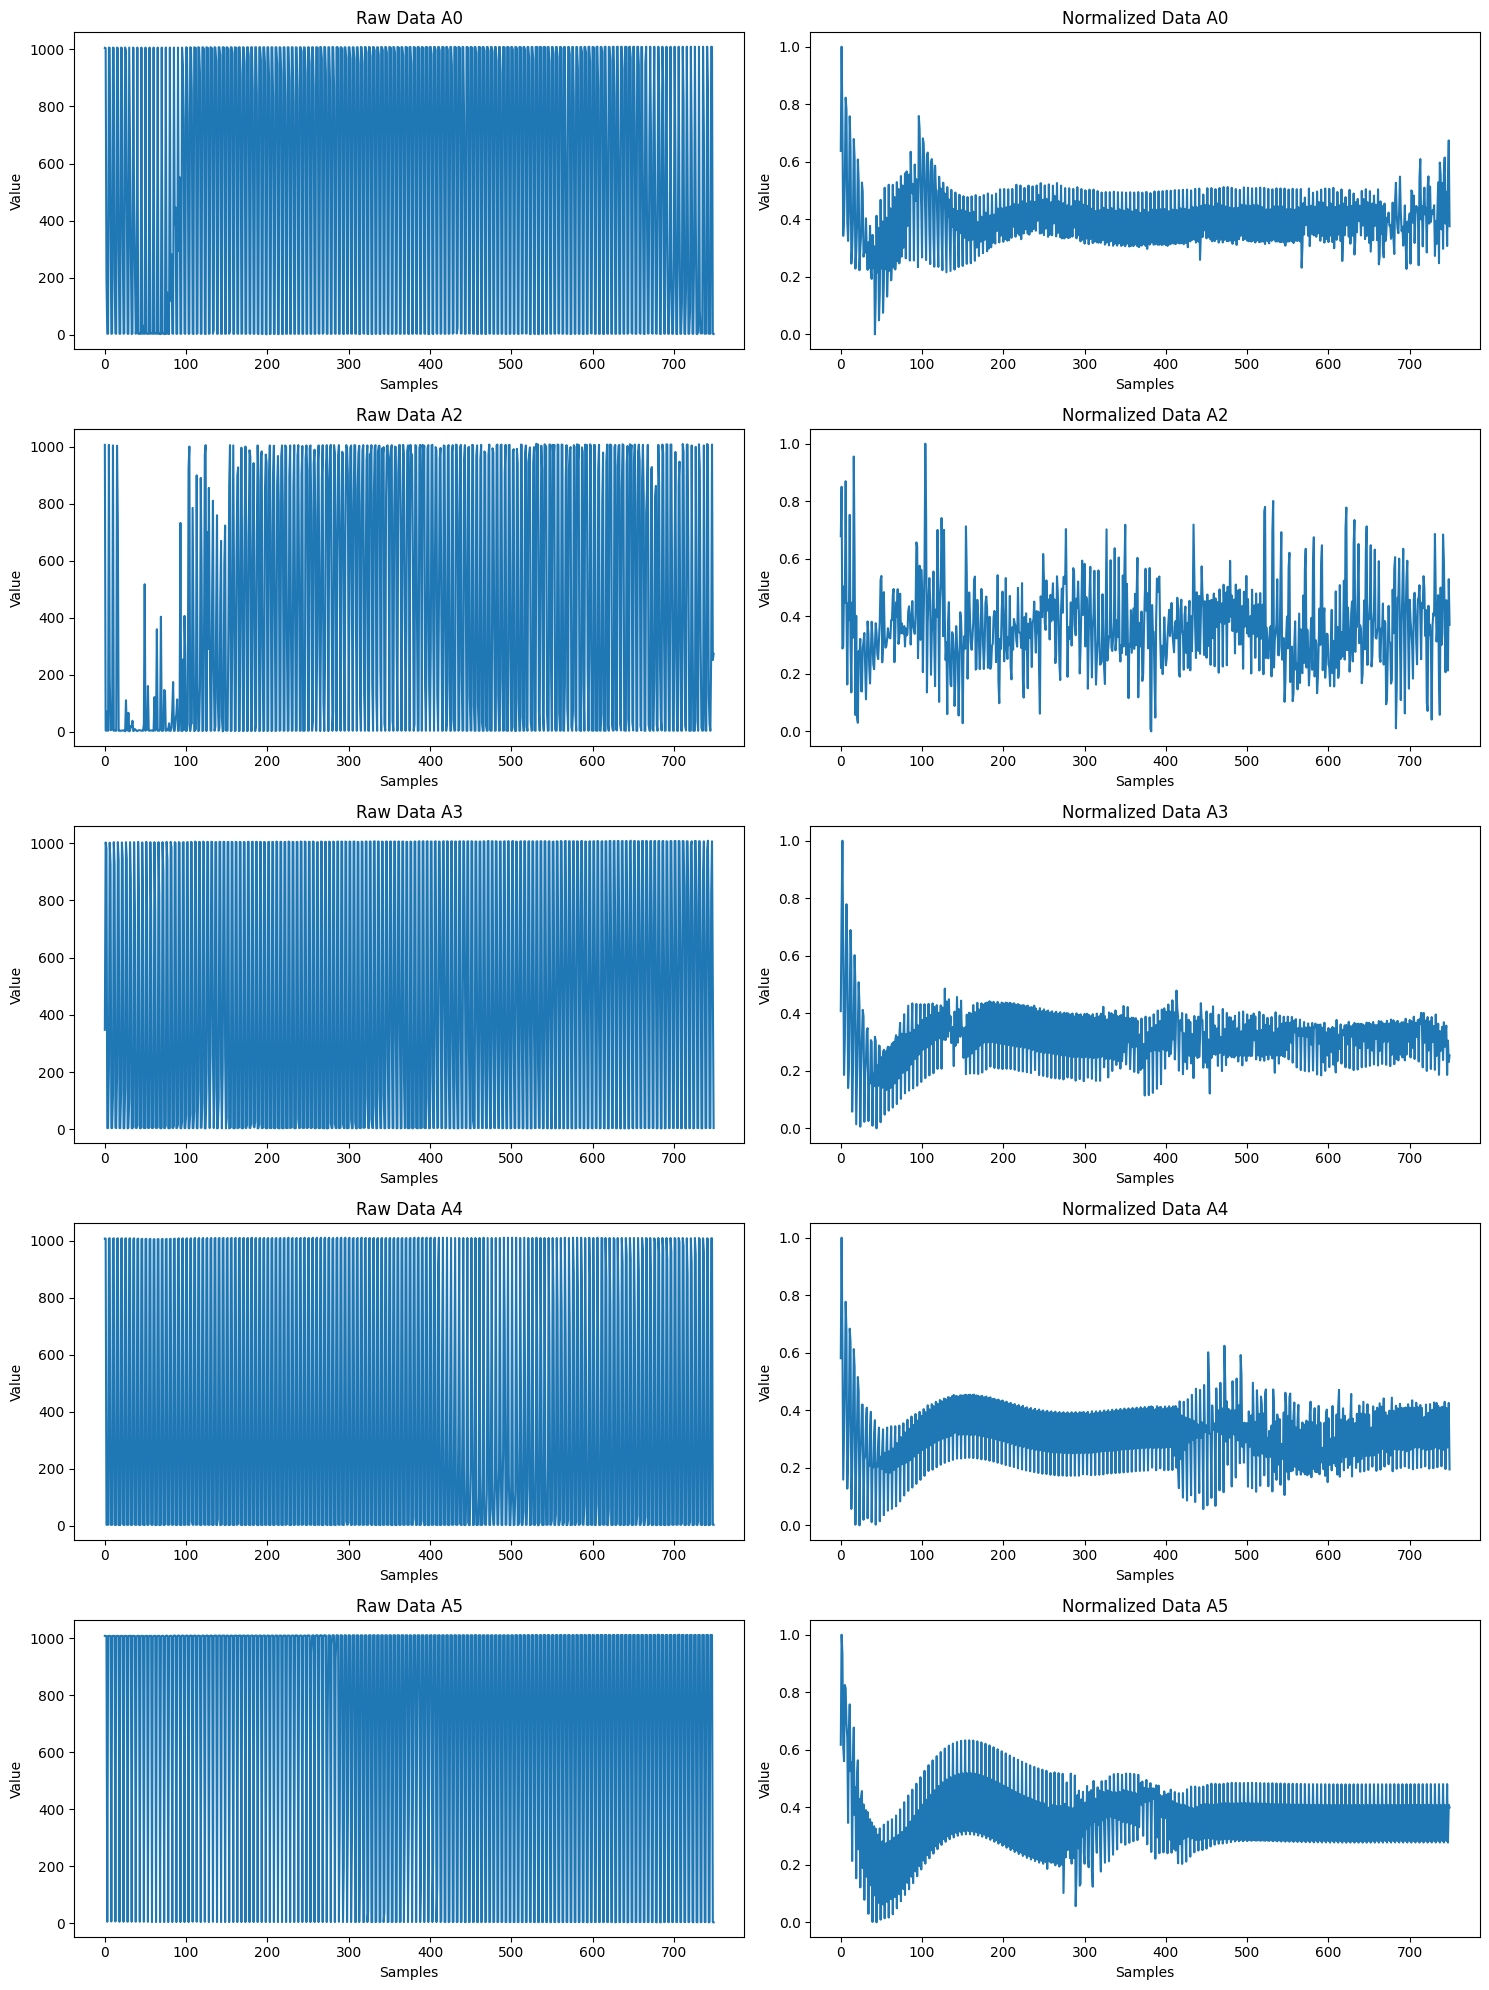

In [2]:
#collection of data from 5 sensors
import serial
import time
import numpy as np
from scipy.signal import butter, lfilter, iirnotch
import matplotlib.pyplot as plt

# Updated Sampling rate and desired filter specifications
fs = 250.0  # Sampling rate, Hz
lowcut = 1.0  # Low cutoff frequency, Hz
highcut = 100.0  # High cutoff frequency, Hz
quality_factor = 20.0  # Quality factor for the notch filter

# Generate a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Generate a notch filter
def design_notch_filter(notch_freq, quality_factor, fs):
    nyq = 0.5 * fs
    freq = notch_freq / nyq
    b, a = iirnotch(freq, quality_factor)
    return b, a

def apply_notch_filter(data, notch_freq, quality_factor, fs):
    b, a = design_notch_filter(notch_freq, quality_factor, fs)
    y = lfilter(b, a, data)
    return y

# Normalize the data to be between 0 and 1
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Initialize your serial connection
ser = serial.Serial('/dev/tty.usbmodem101', 115200, timeout=1)
time.sleep(2)  # Wait for the serial connection to initialize

# Initialize data storage lists for each sensor
data_a0, data_a2, data_a3, data_a4, data_a5 = [], [], [], [], []

print("Starting readings...")
start_time = time.time()

# Collect data for 3 second resulting in 750 points per sensor
sample_count = 0  # Counter for the number of samples collected
while sample_count < 750:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        if "A0:" in line:
            try:
                values = line.split(',')
                data_a0.append(float(values[0].split(":")[1].strip()))
                data_a2.append(float(values[1].split(":")[1].strip()))
                data_a3.append(float(values[2].split(":")[1].strip()))
                data_a4.append(float(values[3].split(":")[1].strip()))
                data_a5.append(float(values[4].split(":")[1].strip()))
                sample_count += 1  # Increment sample_count only on successful parse
            except ValueError:
                print(f"Line skipped: {line}")  # Add this to see the skipped lines
                continue
        else:
            print(f"Line does not contain A0 data: {line}")  # Add this to debug

print("Dimension of data_a0:", len(data_a0))
print("Dimension of data_a2:", len(data_a2))
print("Dimension of data_a3:", len(data_a3))
print("Dimension of data_a4:", len(data_a4))
print("Dimension of data_a5:", len(data_a5))

ser.close()  # Close the serial connection

# ... (rest of the code remains the same)

# Process data_a0
filtered_a0 = butter_bandpass_filter(data_a0, lowcut, highcut, fs)
notched_a0_50 = apply_notch_filter(filtered_a0, 50.0, quality_factor, fs)
notched_a0_60 = apply_notch_filter(notched_a0_50, 60.0, quality_factor, fs)
normalized_a0 = normalize(notched_a0_60)

# Process data_a2
filtered_a2 = butter_bandpass_filter(data_a2, lowcut, highcut, fs)
notched_a2_50 = apply_notch_filter(filtered_a2, 50.0, quality_factor, fs)
notched_a2_60 = apply_notch_filter(notched_a2_50, 60.0, quality_factor, fs)
normalized_a2 = normalize(notched_a2_60)

# Process data_a3
filtered_a3 = butter_bandpass_filter(data_a3, lowcut, highcut, fs)
notched_a3_50 = apply_notch_filter(filtered_a3, 50.0, quality_factor, fs)
notched_a3_60 = apply_notch_filter(notched_a3_50, 60.0, quality_factor, fs)
normalized_a3 = normalize(notched_a3_60)

# Process data_a4
filtered_a4 = butter_bandpass_filter(data_a4, lowcut, highcut, fs)
notched_a4_50 = apply_notch_filter(filtered_a4, 50.0, quality_factor, fs)
notched_a4_60 = apply_notch_filter(notched_a4_50, 60.0, quality_factor, fs)
normalized_a4 = normalize(notched_a4_60)

# Process data_a5
filtered_a5 = butter_bandpass_filter(data_a5, lowcut, highcut, fs)
notched_a5_50 = apply_notch_filter(filtered_a5, 50.0, quality_factor, fs)
notched_a5_60 = apply_notch_filter(notched_a5_50, 60.0, quality_factor, fs)
normalized_a5 = normalize(notched_a5_60)

# Plotting for all sensors
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows for sensors, 2 columns for raw and normalized data

# Helper function to plot data
def plot_sensor_data(axs, row, raw_data, normalized_data, title):
    axs[row, 0].plot(raw_data)
    axs[row, 0].set_title(f'Raw Data {title}')
    axs[row, 0].set_xlabel('Samples')
    axs[row, 0].set_ylabel('Value')

    axs[row, 1].plot(normalized_data)
    axs[row, 1].set_title(f'Normalized Data {title}')
    axs[row, 1].set_xlabel('Samples')
    axs[row, 1].set_ylabel('Value')

# Plot data for A0
plot_sensor_data(axs, 0, data_a0, normalized_a0, 'A0')

# Plot data for A2
plot_sensor_data(axs, 1, data_a2, normalized_a2, 'A2')

# Plot data for A3
plot_sensor_data(axs, 2, data_a3, normalized_a3, 'A3')

# Plot data for A4
plot_sensor_data(axs, 3, data_a4, normalized_a4, 'A4')

# Plot data for A5
plot_sensor_data(axs, 4, data_a5, normalized_a5, 'A5')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

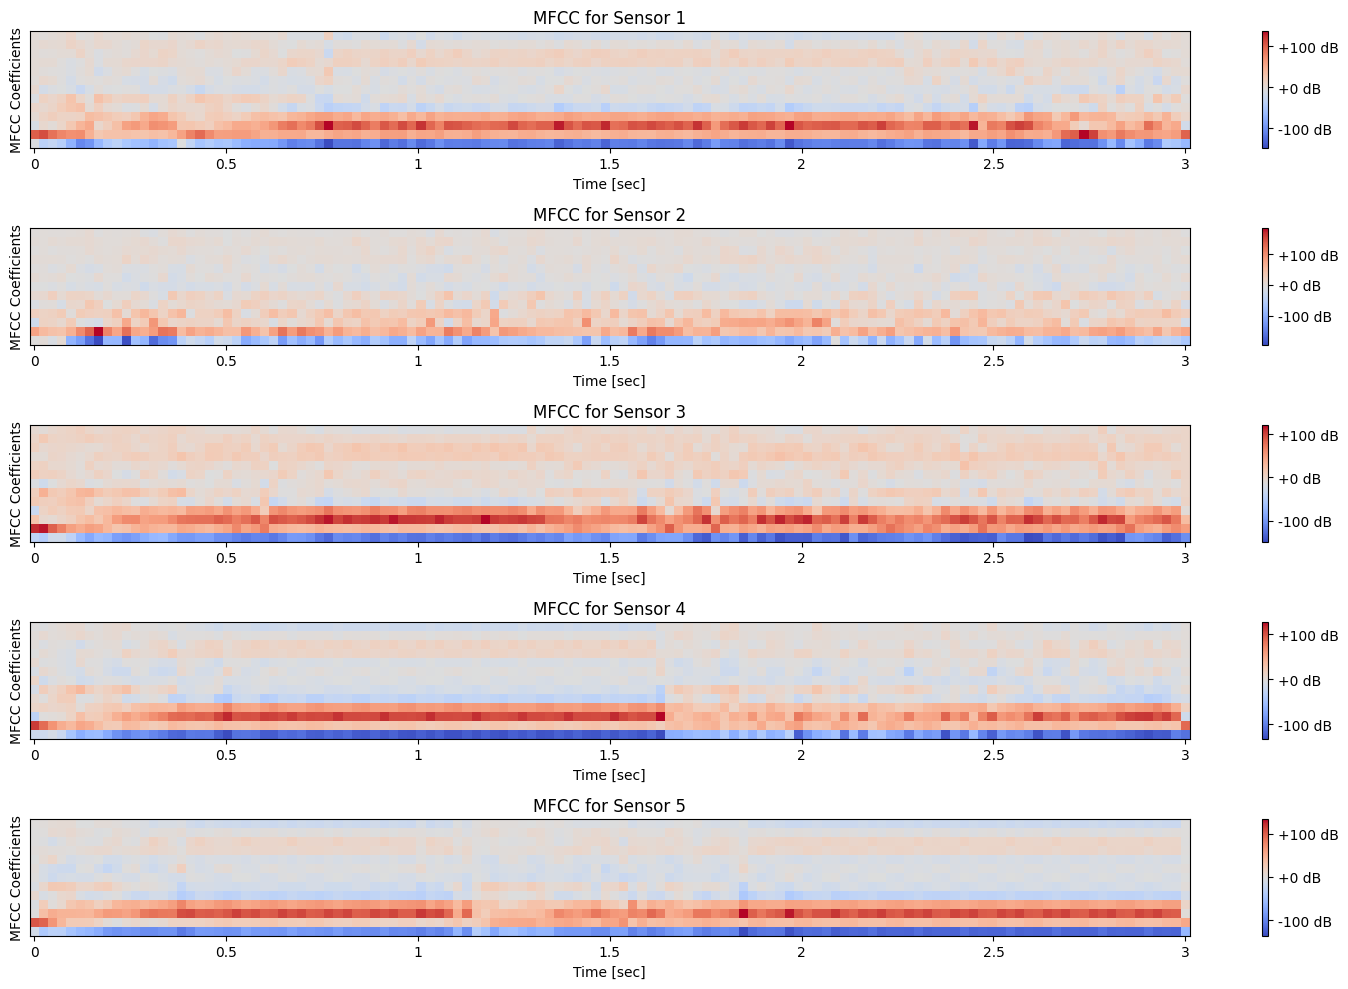

Reshaped MFCC data shape: (126, 65)
Updated array shape: (201, 126, 65)
Updated array saved to 'fiveSensorsMfccData.npy'


In [3]:
#mfcc data set preparation
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_mfccs(sensor_data, fs, plot=True, n_mfcc=13, frame_length_ms=50, hop_length_ms=25):
    frame_length = int(frame_length_ms * fs / 1000)
    hop_length = int(hop_length_ms * fs / 1000)
    n_fft = 512
    frame_length = min(frame_length, n_fft)
    
    mfccs_dimensions = []
    mfccs_data = []
    
    if plot:
        fig, axs = plt.subplots(nrows=len(sensor_data), figsize=(15, 10))
        if len(sensor_data) == 1:
            axs = [axs]
    
    for idx, data in enumerate(sensor_data):
        mfccs = librosa.feature.mfcc(y=data, sr=fs, n_mfcc=n_mfcc, hop_length=hop_length, win_length=frame_length, n_fft=n_fft)
        mfccs_dimensions.append(mfccs.shape)
        mfccs_data.append(mfccs)
        
        if plot:
            img = librosa.display.specshow(mfccs, x_axis='time', ax=axs[idx], sr=fs, hop_length=hop_length)
            fig.colorbar(img, ax=axs[idx], format="%+2.0f dB")
            axs[idx].set_title(f'MFCC for Sensor {idx + 1}')
            axs[idx].set_xlabel('Time [sec]')
            axs[idx].set_ylabel('MFCC Coefficients')
    
    if plot:
        plt.tight_layout()
        plt.show()

    return mfccs_data, mfccs_dimensions

# Step 1: Create a list of normalized sensor data
normalized_data_list = [normalized_a0, normalized_a2, normalized_a3, normalized_a4, normalized_a5]

# Step 2: Calculate and plot MFCCs
mfcc_data, mfccs_dimensions = calculate_and_plot_mfccs(normalized_data_list, fs)

# Reshape the MFCC data for CNN model training
reshaped_mfcc_data = np.array(mfcc_data).reshape(-1, 13*5)

print("Reshaped MFCC data shape:", reshaped_mfcc_data.shape)


import numpy as np
import pickle
import os

# Load the array from the pickle file, or create a new one if it doesn't exist
if os.path.exists('appended_array.pkl'):
    with open('appended_array.pkl', 'rb') as f:
        appended_array = pickle.load(f)
else:
    appended_array = np.array([reshaped_mfcc_data])

# Append the current value of reshaped_mfcc_data to the array
appended_array = np.concatenate((appended_array, [reshaped_mfcc_data]))

# Save the updated array to the pickle file
with open('appended_array.pkl', 'wb') as f:
    pickle.dump(appended_array, f)

# Print the shape of the updated array
print("Updated array shape:", appended_array.shape)

# Save the updated array to a new file
np.save('fiveSensorsMfccData.npy', appended_array)
print("Updated array saved to 'fiveSensorsMfccData.npy'")

In [563]:
#label creation
import numpy as np

# Filename for the NPY file
filename = 'fiveSensorsMfccLabel.npy'

# Data to write: 51 rows with '1' followed by 51 rows with '0'
data = np.array(['1'] * 50 + ['0'] * 50 + ['1'] * 50 + ['0'] * 50)

# Save the data to a NPY file
np.save(filename, data)

# Load the data back to print its dimension
loaded_data = np.load(filename)

print(f"NPY file '{filename}' created with {loaded_data.shape[0]} rows.")
print(f"Dimension of the NPY file: {loaded_data.shape}")

NPY file 'fiveSensorsMfccLabel.npy' created with 200 rows.
Dimension of the NPY file: (200,)


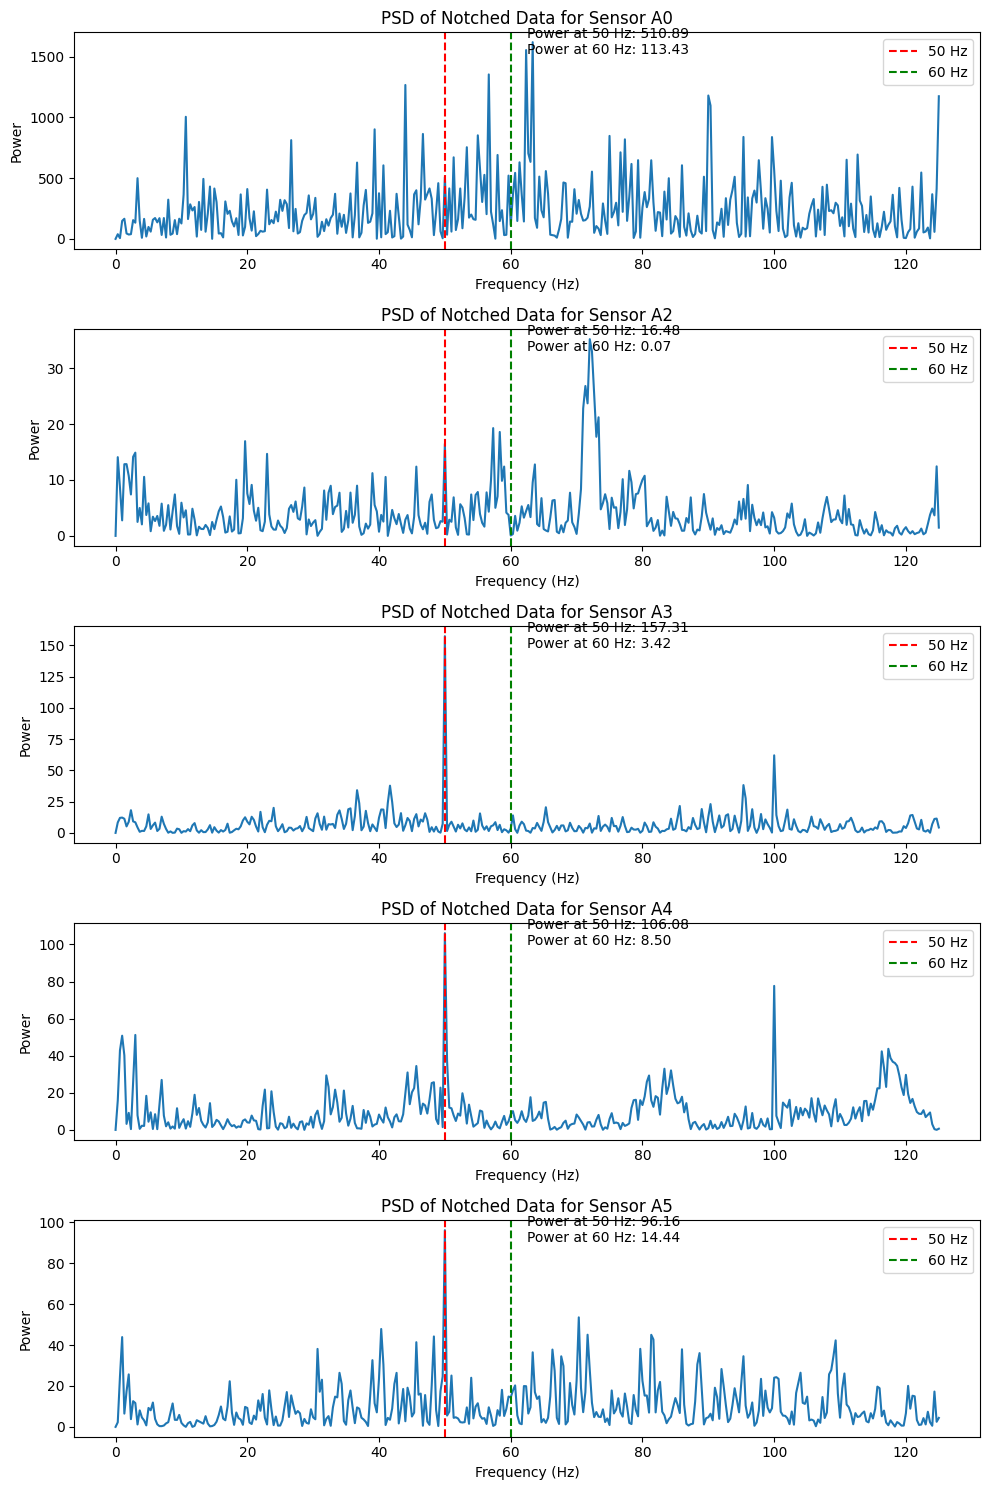

In [221]:
#fft
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import periodogram

def calculate_psd(data, fs):
    freqs, psd = periodogram(data, fs=fs)
    return freqs, psd

def plot_psd(freqs, psd, title, ax):
    ax.plot(freqs, psd)
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.axvline(50, color='r', linestyle='--', label='50 Hz')
    ax.axvline(60, color='g', linestyle='--', label='60 Hz')
    ax.legend()
    power_50 = psd[np.argmin(np.abs(freqs-50))]
    power_60 = psd[np.argmin(np.abs(freqs-60))]
    ax.text(0.5, 0.9, f'Power at 50 Hz: {power_50:.2f}\nPower at 60 Hz: {power_60:.2f}', transform=ax.transAxes)

# Calculate PSD for each dataset
datasets = [data_a0, data_a2, data_a3, data_a4, data_a5]
psd_data = []
for data in datasets:
    freqs, psd = calculate_psd(data, fs)
    psd_data.append((freqs, psd))

# Create a figure with 5 subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# Plot the PSD of each sensor's data
titles = ['PSD of Notched Data for Sensor A0', 'PSD of Notched Data for Sensor A2', 
         'PSD of Notched Data for Sensor A3', 'PSD of Notched Data for Sensor A4', 
         'PSD of Notched Data for Sensor A5']
for i, (freqs, psd) in enumerate(psd_data):
    plot_psd(freqs, psd, titles[i], axs[i])

# Show the plot
plt.tight_layout()
plt.show()